In [1]:
# standard imports 
import pandas as pd 
import numpy as np 

# bayesian modeling 
import pymc as pm
import xarray as xr 

# visualizations
import matplotlib.pyplot as plt 
import arviz as az 
%matplotlib inline

# transformers 
from sklearn.preprocessing import OneHotEncoder

In [2]:
# reading in our dataset 

nys_gradrates_df = pd.read_csv("data/2022_nys_gradrates_compiled.csv")

In [3]:
# previewing first five rows of our dataset
nys_gradrates_df.head()

,entity_cd,county,district,nrc_index,school,year,subgroup,grad_rate
0,10100010034,Albany,Albany City Sd,3,Albany High School,2022,Hispanic or Latino,73.7
1,10100010034,Albany,Albany City Sd,3,Albany High School,2022,White,86.9
2,10100010034,Albany,Albany City Sd,3,Albany High School,2022,Multiracial,77.4
3,10100010034,Albany,Albany City Sd,3,Albany High School,2022,English Language Learner,70.4
4,10100010034,Albany,Albany City Sd,3,Albany High School,2022,Economically Disadvantaged,75.5


In [4]:
# transforming subgroups into binary form using pd.getdummies
subgroup_enc = pd.get_dummies(nys_gradrates_df.subgroup,dtype='int64')

# concatenating our two dataframes 
nys_gradrates_df = pd.concat([nys_gradrates_df,subgroup_enc],axis=1)

# dropping the pre-encoded subgroup column
nys_gradrates_df = nys_gradrates_df.drop(columns=["subgroup"])

# shifting column order for readability
nys_gradrates_df = nys_gradrates_df[["entity_cd","county","district","nrc_index","school","year",
                  "American Indian or Alaska Native", "Asian or Native Hawaiian/Other Pacific Islander",
                  "Black or African American","Economically Disadvantaged","English Language Learner",
                  "Hispanic or Latino","Multiracial","Students with Disabilities","White","grad_rate"]]

In [5]:
nys_gradrates_df.head()

,entity_cd,county,district,nrc_index,school,year,American Indian or Alaska Native,Asian or Native Hawaiian/Other Pacific Islander,Black or African American,Economically Disadvantaged,English Language Learner,Hispanic or Latino,Multiracial,Students with Disabilities,White,grad_rate
0,10100010034,Albany,Albany City Sd,3,Albany High School,2022,0,0,0,0,0,1,0,0,0,73.7
1,10100010034,Albany,Albany City Sd,3,Albany High School,2022,0,0,0,0,0,0,0,0,1,86.9
2,10100010034,Albany,Albany City Sd,3,Albany High School,2022,0,0,0,0,0,0,1,0,0,77.4
3,10100010034,Albany,Albany City Sd,3,Albany High School,2022,0,0,0,0,1,0,0,0,0,70.4
4,10100010034,Albany,Albany City Sd,3,Albany High School,2022,0,0,0,1,0,0,0,0,0,75.5


In [6]:
# number of unique districts
len(nys_gradrates_df.district.unique())

660

In [7]:
# number of unique counties 
len(nys_gradrates_df.county.unique())

62

In [8]:
# number of unique schools
len(nys_gradrates_df.school.unique())

1240

<Axes: >

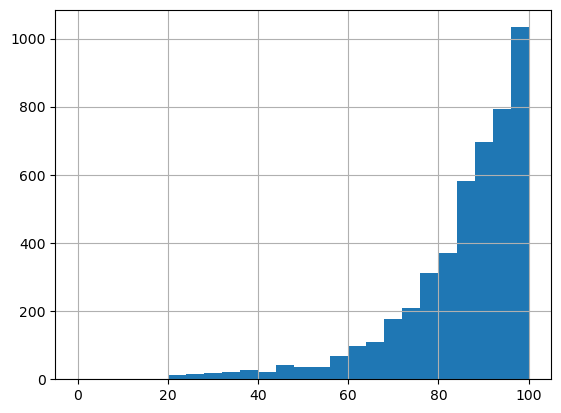

In [21]:
nys_gradrates_df.grad_rate.hist(bins=25)

## Hierarchical Bayesian Modeling

To build up to a hierarchical model, we'll start off simple, trying to predict 

In [23]:
r_seed = 205

In [10]:
# creating a lookup dictionary for indexing

nys_counties = nys_gradrates_df.county.unique() # list of all unique counties 
n_counties = len(nys_counties) # 62 unique counties
county_lookup = dict(zip(nys_counties, range(n_counties))) # dictionary with county name and index 

In [12]:
# creating local copies of variables for future models 
county = nys_gradrates_df["county_code"] = nys_gradrates_df.county.replace(county_lookup).values
grad_rate = nys_gradrates_df.grad_rate # predictor var: float64

# index variables for each subgroup 
hisp_latx = nys_gradrates_df['Hispanic or Latino'].values
ells = nys_gradrates_df['English Language Learner'].values
amer_native = nys_gradrates_df['American Indian or Alaska Native'].values
aapi = nys_gradrates_df['Asian or Native Hawaiian/Other Pacific Islander'].values
aa_blk = nys_gradrates_df['Black or African American'].values
swd = nys_gradrates_df['Students with Disabilities'].values
white = nys_gradrates_df['White'].values
multiracial = nys_gradrates_df['Multiracial'].values
econ_disadv = nys_gradrates_df['Economically Disadvantaged'].values

### Pooled Model 

For simplicity's sake, we'll build a simple model 

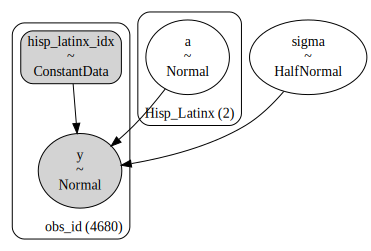

In [22]:
# setting up the dimensions of our model
coords = {"Hisp_Latinx":[0,1], "obs_id": np.arange(hisp_latx.size)}

# building up our model 
with pm.Model(coords=coords) as pooled_model: 
    hisp_latinx_idx = pm.ConstantData("hisp_latinx_idx", hisp_latx, dims = "obs_id")
    # setting up priors 
    a = pm.Normal("a", 80.0, sigma=5.0, dims="Hisp_Latinx")
    
    theta = a[hisp_latinx_idx]
    sigma = pm.HalfNormal("sigma",1.0)
    
    y = pm.Normal("y", theta, sigma=sigma, observed=grad_rate, dims="obs_id")
pm.model_to_graphviz(pooled_model)

Sampling: [a, sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


Text(0, 0.5, 'Average Graduation Rate')

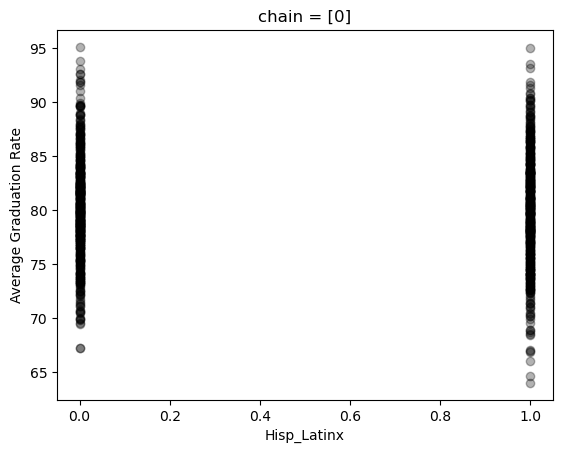

In [39]:
with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=r_seed)
    idata_prior = prior_checks.extend(pm.sample())
    
_, ax = plt.subplots()
prior_checks.prior.plot.scatter(x='Hisp_Latinx',y="a",color="k",alpha=0.3,ax=ax)
ax.set_ylabel("Average Graduation Rate");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


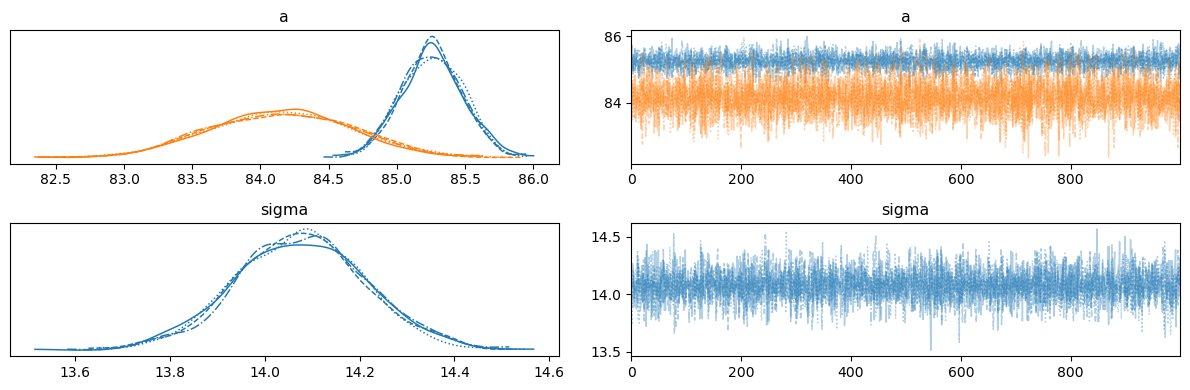

In [45]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=r_seed)
    pooled_idata = az.plot_trace(pooled_trace)
az.summary(pooled_trace)
plt.tight_layout()

### Unpooled Model 

The unpooled model ...

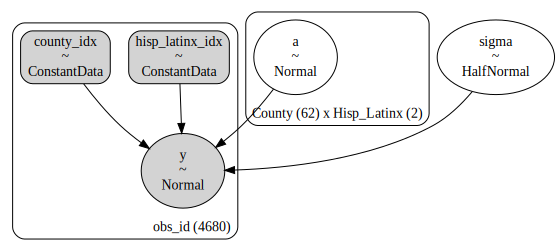

In [50]:
# updating the dimensions of our model
coords["County"] = nys_counties

# building up our unpooled model 
with pm.Model(coords=coords) as unpooled_model:
    hisp_latinx_idx = pm.ConstantData("hisp_latinx_idx", hisp_latx, dims = "obs_id")
    county_idx = pm.ConstantData("county_idx", county, dims="obs_id")
    # setting up our priors 
    a = pm.Normal("a", 80.0, sigma=5.0, dims=("County","Hisp_Latinx"))
    
    theta = a[county_idx,hisp_latinx_idx]
    sigma = pm.HalfNormal("sigma",1.0)
    
    y = pm.Normal("y",theta, sigma=sigma, observed=grad_rate,dims="obs_id")
pm.model_to_graphviz(unpooled_model)

In [51]:
with unpooled_model:
    unpooled_idata = pm.sample(return_inferencedata=True, random_seed=r_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


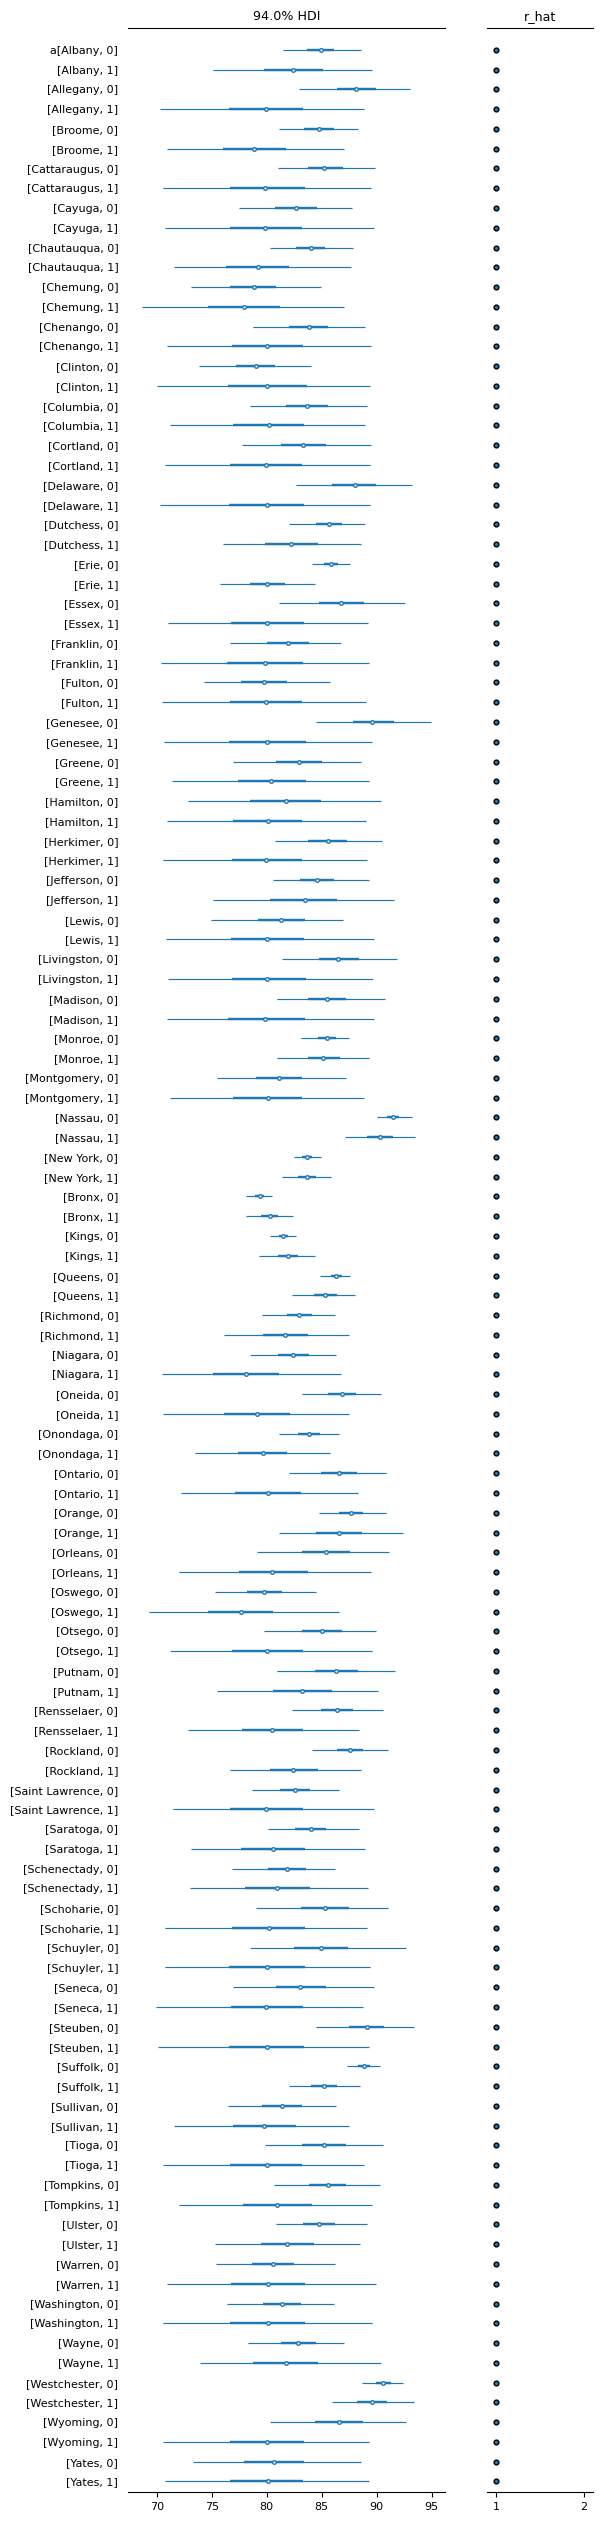

In [52]:
# expected values for effect of being Hispanic/Latinx subgroup in each county 
az.plot_forest(unpooled_idata, var_names="a", figsize=(6, 32), r_hat=True, combined=True, textsize=8);

In [54]:
unpooled_means = unpooled_idata.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_idata)

### Hierarchical Model 

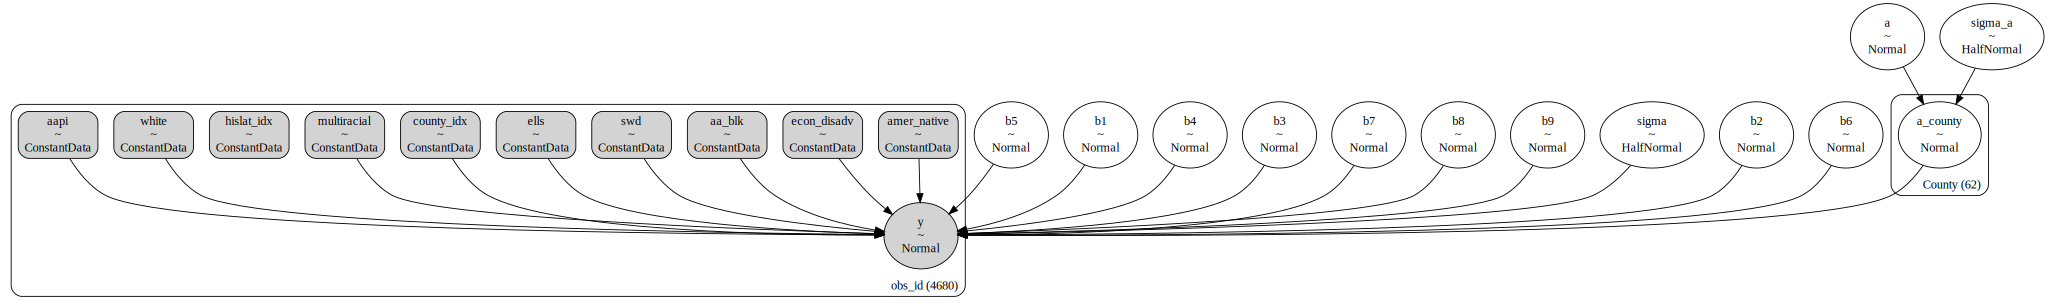

In [63]:
with pm.Model(coords=coords) as varying_intercept:
    # adding our county level index variables
    county_idx = pm.ConstantData("county_idx", county,dims="obs_id") 
    # adding subgroup index variables 
    hislat_idx = pm.ConstantData("hislat_idx",hisp_latx,dims="obs_id")
    ells_idx = pm.ConstantData("ells",ells, dims="obs_id")
    amer_native_idx = pm.ConstantData("amer_native",amer_native,dims="obs_id")
    aapi_idx = pm.ConstantData("aapi", aapi, dims="obs_id")
    aablk_idx = pm.ConstantData("aa_blk", aa_blk, dims="obs_id") 
    swd_idx = pm.ConstantData("swd",swd, dims="obs_id")
    white_idx = pm.ConstantData("white", white, dims="obs_id")
    multiracial_idx = pm.ConstantData("multiracial", multiracial, dims="obs_id")
    econ_disadv_idx = pm.ConstantData("econ_disadv", econ_disadv, dims="obs_id")
    
    # hyperpriors 
    a = pm.Normal("a", 80.0, sigma=5.0)
    sigma_a = pm.HalfNormal("sigma_a",1.0)
    
    # varying intercepts 
    a_county = pm.Normal("a_county",mu=a,sigma=sigma_a,dims="County")
    # common slopes 
    b1 = pm.Normal("b1",mu=0.0, sigma=5.0)
    b2 = pm.Normal("b2",mu=0.0, sigma=5.0)
    b3 = pm.Normal("b3",mu=0.0, sigma=5.0)
    b4 = pm.Normal("b4",mu=0.0, sigma=5.0)
    b5 = pm.Normal("b5",mu=0.0, sigma=5.0)
    b6 = pm.Normal("b6",mu=0.0, sigma=5.0)
    b7 = pm.Normal("b7",mu=0.0, sigma=5.0)
    b8 = pm.Normal("b8",mu=0.0, sigma=5.0)
    b9 = pm.Normal("b9",mu=0.0, sigma=5.0)
    
    # expected values per county: 
    theta = a_county[county_idx] + (b1 * hisp_latinx_idx) + (b2 * ells_idx) + (b3 * amer_native_idx) + (b4 * aapi_idx) +(b5 * aablk_idx) + (b6 * swd_idx) + (b7 * white_idx) + (b8 * multiracial_idx) + (b9 * econ_disadv_idx)
    # model error 
    sigma = pm.HalfNormal("sigma", 1.0)
    
    y = pm.Normal("y", theta, sigma=sigma, observed=grad_rate,dims="obs_id")
    
pm.model_to_graphviz(varying_intercept)

In [65]:
with varying_intercept:
    varying_intercept_idata = pm.sample(
        tune=2000, init="adapt_diag", random_seed=r_seed, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma_a, a_county, b1, b2, b3, b4, b5, b6, b7, b8, b9, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 56 seconds.


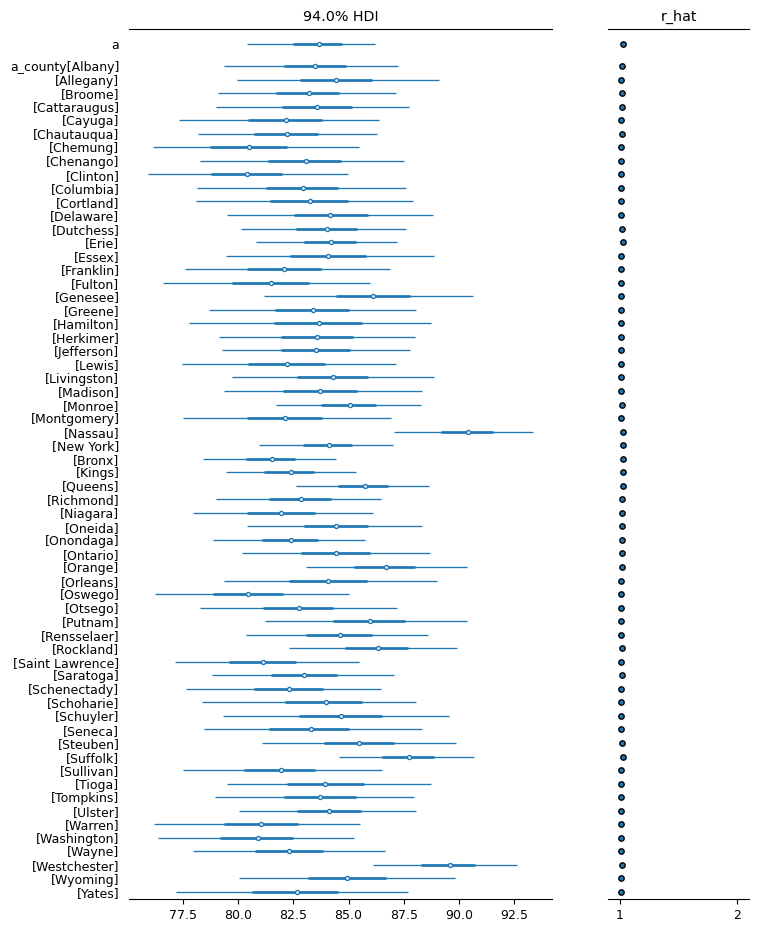

In [66]:
az.plot_forest(
    varying_intercept_idata, var_names=["a", "a_county"], r_hat=True, combined=True, textsize=9
);

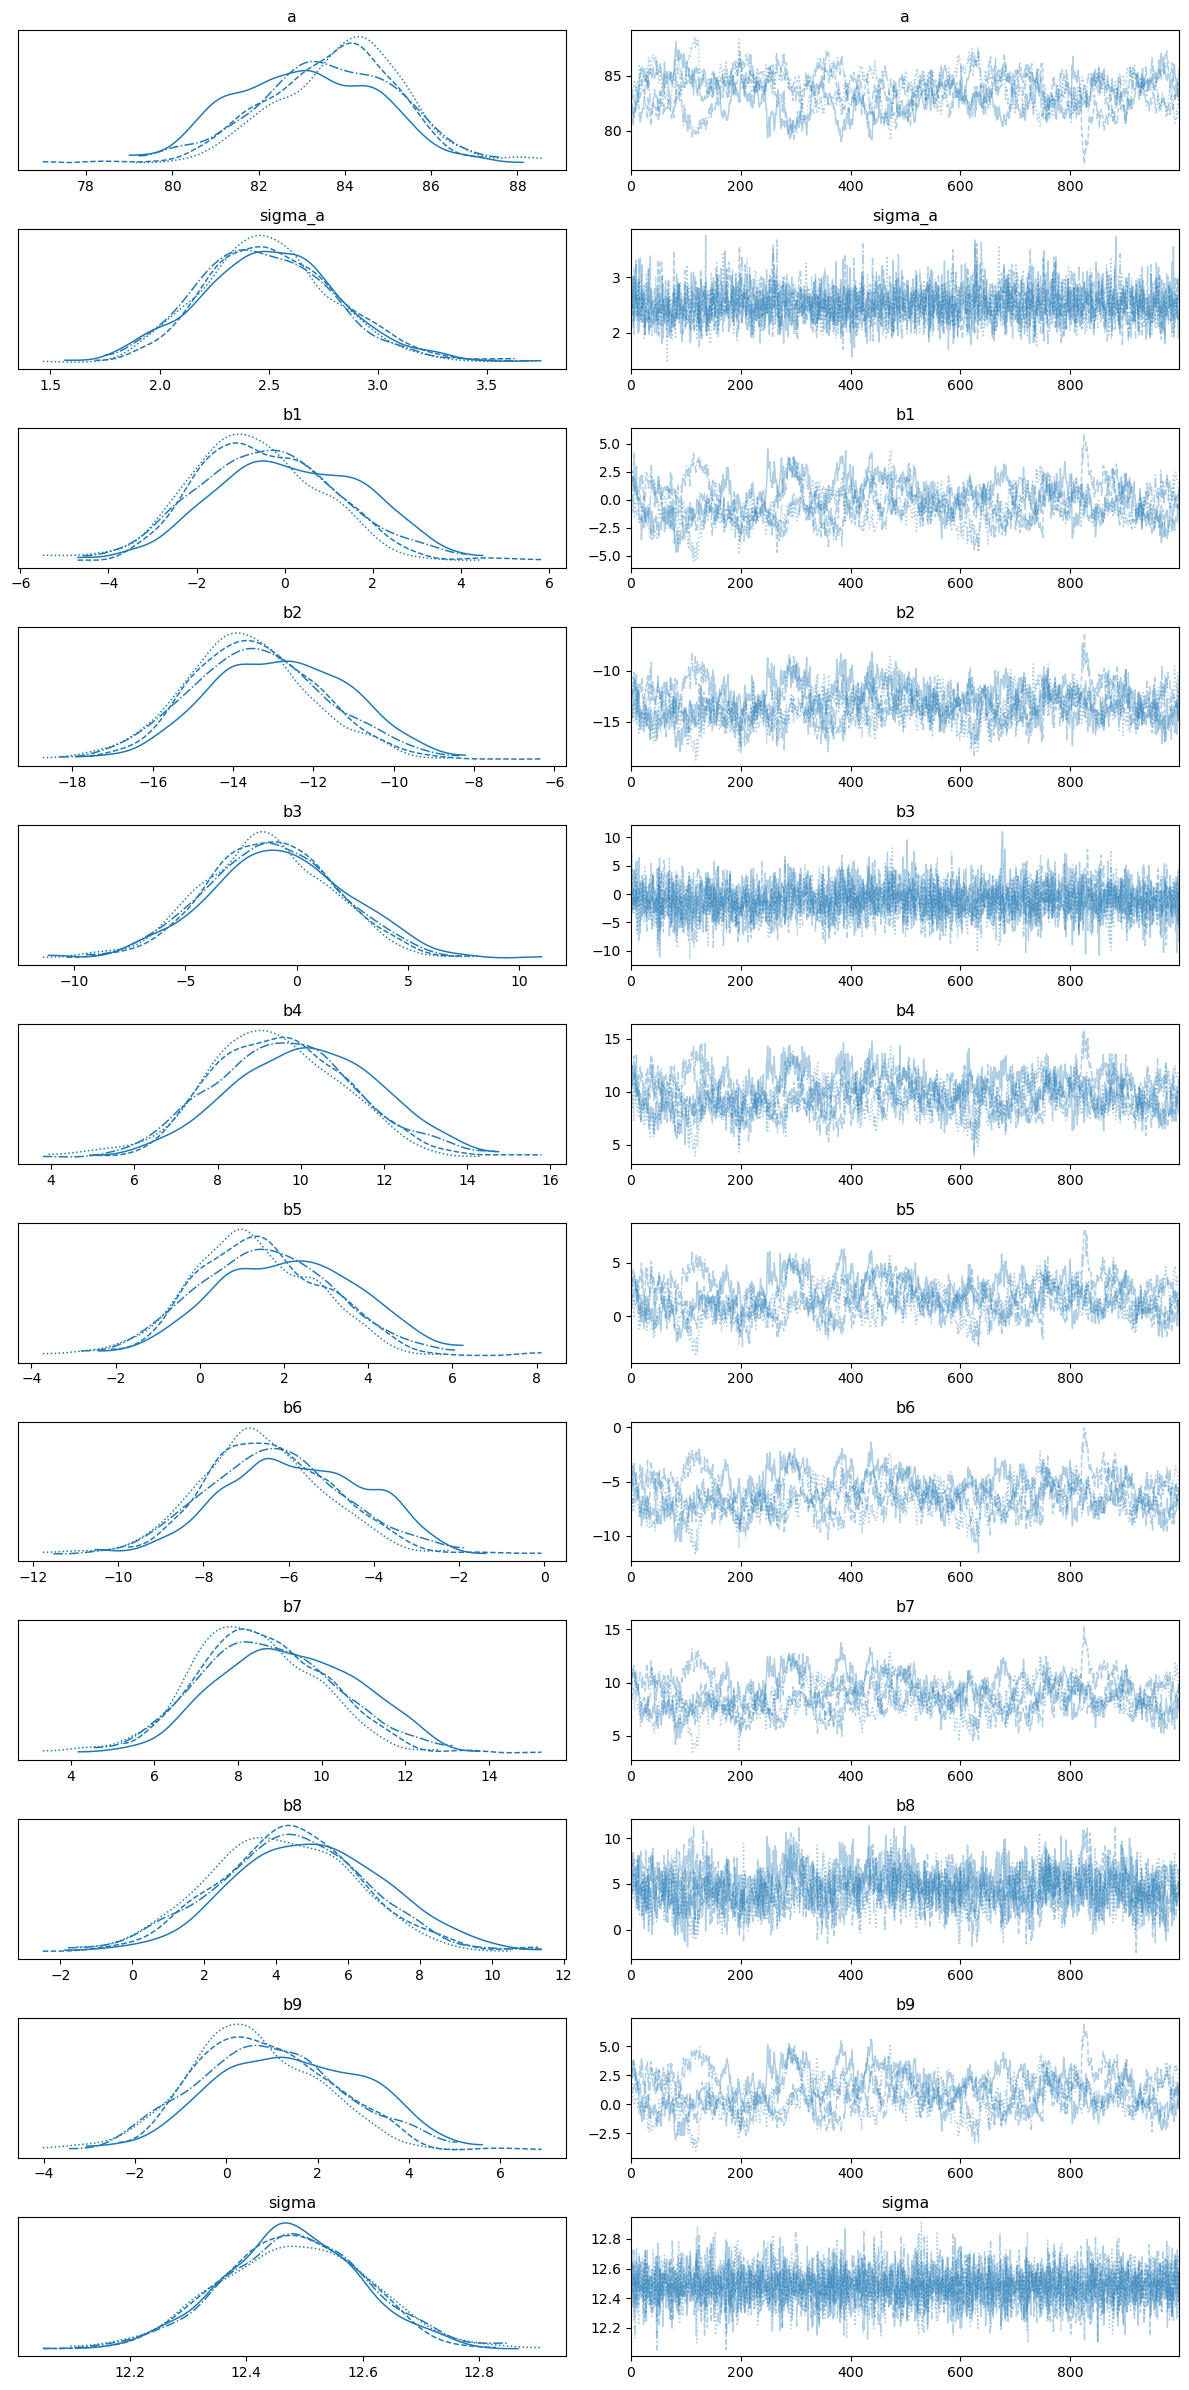

In [69]:
az.plot_trace(varying_intercept_idata, var_names=["a", "sigma_a", "b1","b2","b3","b4","b5","b6","b7",
                                                  "b8","b9", "sigma"])
plt.tight_layout()
plt.show()

In [71]:
# summary of coefficients
az.summary(varying_intercept_idata, var_names=["a", "sigma_a", "b1","b2","b3","b4","b5","b6","b7",
                                               "b8","b9", "sigma"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,83.57,1.59,80.37,86.18,0.17,0.12,90.09,143.67,1.03
sigma_a,2.50,0.31,1.90,3.05,0.01,0.00,2022.52,2635.49,1.00
b1,-0.33,1.61,-2.91,3.04,0.17,0.12,95.11,179.03,1.03
b2,-13.32,1.69,-16.47,-10.17,0.16,0.11,109.63,284.87,1.02
b3,-1.10,2.98,-6.42,4.65,0.12,0.08,625.29,1861.30,1.00
b4,9.66,1.71,6.48,12.79,0.17,0.12,107.71,240.03,1.02
b5,1.62,1.62,-1.27,4.62,0.16,0.12,97.67,183.75,1.03
b6,-6.27,1.60,-9.10,-3.26,0.17,0.12,94.16,146.07,1.03
b7,8.74,1.60,5.78,11.70,0.17,0.12,91.52,107.53,1.03
b8,4.47,2.11,0.38,8.25,0.15,0.11,189.86,676.14,1.01
